In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

X_train = pd.read_csv('../data/modeling/X_train.csv')
y_train = pd.read_csv('../data/modeling/y_train.csv').values.ravel()
X_test = pd.read_csv('../data/modeling/X_test.csv')
test_ids = pd.read_csv('../data/modeling/test_ids.csv')

print(f"X_train: {X_train.shape}")
print(f"Baseline enrollment rate: {y_train.mean():.1%}")

X_train: (7461, 62)
Baseline enrollment rate: 49.6%


### Lift & Gains Analysis

Since we're ranking prospects for outreach (not making a hard yes/no cutoff), the right question to evaluate a model on is:

"If I contact the top X% of my ranked list, how many enrollers do I capture?"

This is what lift and cumulative gains curves show us.

In [2]:
def calc_cumulative_gains(y_true, y_prob):
    """Calculate cumulative gains at each decile."""
    df = pd.DataFrame({'y': y_true, 'prob': y_prob})
    df = df.sort_values('prob', ascending=False).reset_index(drop=True)
    
    total_positives = df['y'].sum()
    n = len(df)
    
    percentiles = np.arange(0.1, 1.1, 0.1)
    gains = []
    
    for p in percentiles:
        cutoff = int(n * p)
        captured = df['y'].iloc[:cutoff].sum()
        gains.append(captured / total_positives)
    
    return percentiles, gains


def calc_lift(y_true, y_prob):
    """Calculate lift at each decile."""
    df = pd.DataFrame({'y': y_true, 'prob': y_prob})
    df = df.sort_values('prob', ascending=False).reset_index(drop=True)
    
    baseline_rate = df['y'].mean()
    n = len(df)
    
    percentiles = np.arange(0.1, 1.1, 0.1)
    lifts = []
    
    for p in percentiles:
        cutoff = int(n * p)
        segment_rate = df['y'].iloc[:cutoff].mean()
        lifts.append(segment_rate / baseline_rate)
    
    return percentiles, lifts

In [3]:
# models to compare
models = {
    'Logistic Regression': (LogisticRegression(max_iter=1000, random_state=42), True),
    'Random Forest': (RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42), False),
    'XGBoost': (XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, eval_metric='logloss'), False),
    'SVM': (SVC(kernel='rbf', probability=True, random_state=42), True)
}

In [4]:
# run CV and collect predictions for lift/gains
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model_results = {}

for name, (model, needs_scaling) in models.items():
    print(f"Training {name}...")
    
    all_y_true = []
    all_y_prob = []
    aucs = []
    
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx].copy(), X_train.iloc[val_idx].copy()
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        if needs_scaling:
            scaler = StandardScaler()
            X_tr = scaler.fit_transform(X_tr)
            X_val = scaler.transform(X_val)
        
        model.fit(X_tr, y_tr)
        y_prob = model.predict_proba(X_val)[:, 1]
        
        all_y_true.extend(y_val)
        all_y_prob.extend(y_prob)
        aucs.append(roc_auc_score(y_val, y_prob))
    
    model_results[name] = {
        'y_true': np.array(all_y_true),
        'y_prob': np.array(all_y_prob),
        'auc': np.mean(aucs)
    }
    print(f"  AUC: {np.mean(aucs):.4f}")

print("\nDone.")

Training Logistic Regression...
  AUC: 0.7362
Training Random Forest...
  AUC: 0.7295
Training XGBoost...
  AUC: 0.7344
Training SVM...
  AUC: 0.7210

Done.


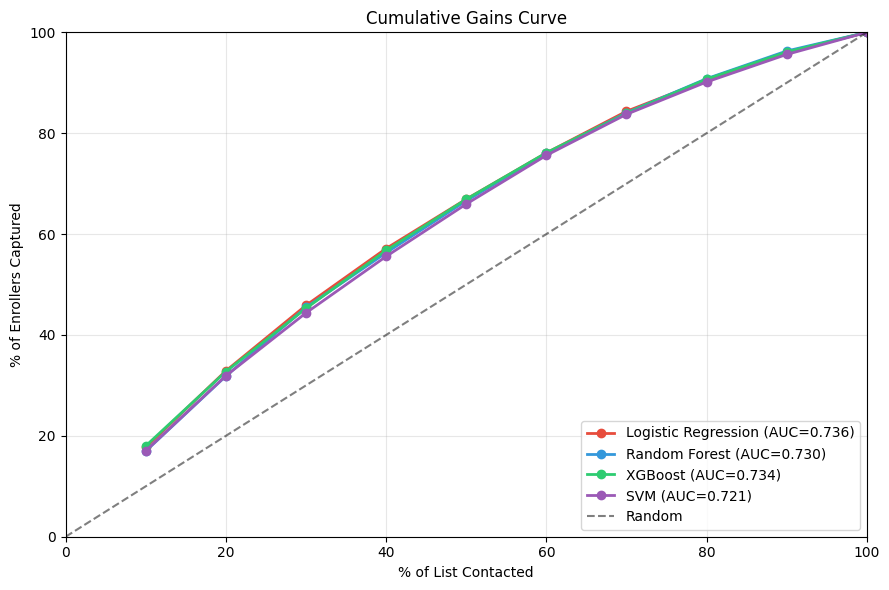

In [5]:
# cumulative gains curves
fig, ax = plt.subplots(figsize=(9, 6))

colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']

for (name, data), color in zip(model_results.items(), colors):
    pct, gains = calc_cumulative_gains(data['y_true'], data['y_prob'])
    ax.plot(pct * 100, np.array(gains) * 100, marker='o', label=f"{name} (AUC={data['auc']:.3f})", 
            linewidth=2, color=color)

# random baseline
ax.plot([0, 100], [0, 100], 'k--', alpha=0.5, label='Random')

ax.set_xlabel('% of List Contacted')
ax.set_ylabel('% of Enrollers Captured')
ax.set_title('Cumulative Gains Curve')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()

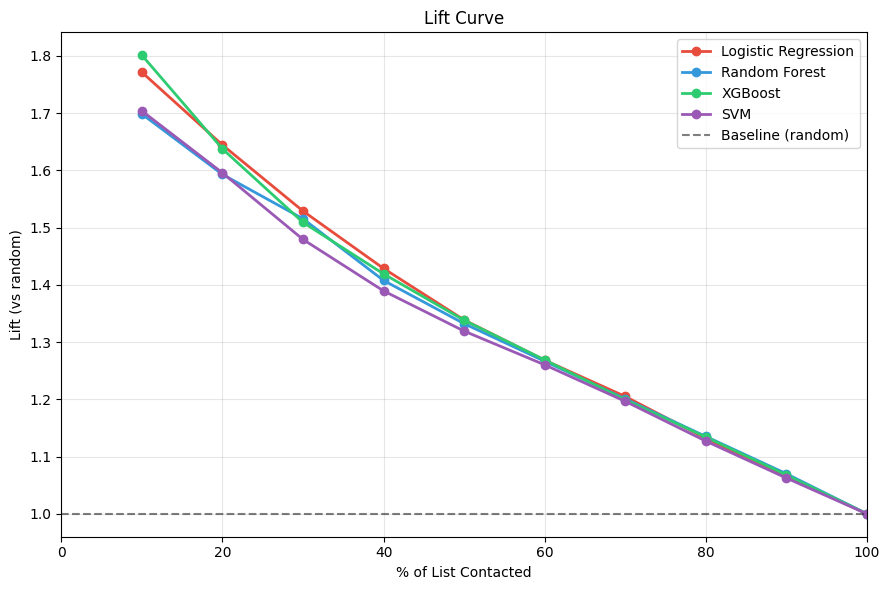

In [6]:
# lift curves
fig, ax = plt.subplots(figsize=(9, 6))

for (name, data), color in zip(model_results.items(), colors):
    pct, lifts = calc_lift(data['y_true'], data['y_prob'])
    ax.plot(pct * 100, lifts, marker='o', label=name, linewidth=2, color=color)

ax.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Baseline (random)')

ax.set_xlabel('% of List Contacted')
ax.set_ylabel('Lift (vs random)')
ax.set_title('Lift Curve')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 100)

plt.tight_layout()
plt.show()

In [7]:
# summary table
summary = []

for name, data in model_results.items():
    pct, gains = calc_cumulative_gains(data['y_true'], data['y_prob'])
    _, lifts = calc_lift(data['y_true'], data['y_prob'])
    
    summary.append({
        'Model': name,
        'AUC': data['auc'],
        'Gain@10%': gains[0],   # top 10%
        'Gain@20%': gains[1],   # top 20%
        'Gain@30%': gains[2],   # top 30%
        'Lift@10%': lifts[0],
        'Lift@20%': lifts[1]
    })

summary_df = pd.DataFrame(summary).sort_values('AUC', ascending=False)
summary_df.style.format({
    'AUC': '{:.4f}',
    'Gain@10%': '{:.1%}',
    'Gain@20%': '{:.1%}',
    'Gain@30%': '{:.1%}',
    'Lift@10%': '{:.2f}x',
    'Lift@20%': '{:.2f}x'
})

,Model,AUC,Gain@10%,Gain@20%,Gain@30%,Lift@10%,Lift@20%
0,Logistic Regression,0.7362,17.7%,32.9%,45.9%,1.77x,1.64x
2,XGBoost,0.7344,18.0%,32.7%,45.3%,1.80x,1.64x
1,Random Forest,0.7295,17.0%,31.9%,45.5%,1.70x,1.59x
3,SVM,0.7210,17.0%,31.9%,44.4%,1.70x,1.60x


### Interpretation

- **Gain@20%**: If we contact the top 20% of our ranked list, we capture X% of all enrollers
- **Lift@10%**: The top 10% of our list enrolls at Xx the baseline rate

Higher is better for both. A lift of 1.0 = no better than random.

We will go with logistic regression

In [8]:
print(X_test.isnull().sum().sum())  # total NaNs                                                                                                                                                                                                                             
print(X_test.isnull().sum()[X_test.isnull().sum() > 0])  # which columns if any

216
bbq_interest    216
dtype: int64


bbq interest has a whole bunch of nans. There are sophisticated ways to impute the missing values, we can even build a model to impute missing values, but for now we can just go with the median and impute it that way.

In [9]:
# retrain on full data                                                                                                                                                                                                                                                       
best_model, needs_scaling = models['Logistic Regression']                                                                                                                                                                                                                    
                                                                                                                                                                                                                                                                            
if needs_scaling:                                                                                                                                                                                                                                                            
    scaler = StandardScaler()                                                                                                                                                                                                                                                
    X_train_final = scaler.fit_transform(X_train.fillna(X_train.median()))                                                                                                                                                                                                   
    X_test_final = scaler.transform(X_test.fillna(X_test.median()))                                                                                                                                                                                                          
else:                                                                                                                                                                                                                                                                        
    X_train_final = X_train.fillna(X_train.median())                                                                                                                                                                                                                         
    X_test_final = X_test.fillna(X_test.median())                                                                                                                                                                                                                            
                                                                                                                                                                                                                                                                            
best_model.fit(X_train_final, y_train)                                                                                                                                                                                                                                       
houston_probs = best_model.predict_proba(X_test_final)[:, 1]                                                                                                                                                                                                                 
                                                                                                                                                                                                                                                                            
print(f"Houston data scored: {len(houston_probs)}")

Houston data scored: 2539


In [10]:
output = pd.DataFrame({
    'id': test_ids['id'],
    'enrollment_probability': houston_probs
}).sort_values('enrollment_probability', ascending=False)

output['rank'] = range(1, len(output) + 1)
output.head(20)

,id,enrollment_probability,rank
1737,fa53aec85cee27761661186d432541bd,0.998165,1
1035,526123f5e7e55990a4331a3f807f1c9c,0.996989,2
928,eddbf086298d195bb53402baf406f982,0.996979,3
2387,bb5626584aa00e2b55f0b1fef9217a78,0.996480,4
1797,77f7610934c8e3e64764602f45203c9c,0.995484,5
2202,50c0844960c47f3d1165041660b5c634,0.995289,6
1638,dc61f38afd43841d97335548f202fb48,0.994861,7
1739,85a16333cf616f9dbd75a4702dbd728d,0.994805,8
1877,bf21b0d8e5ac88fe14751636d84796b1,0.994758,9
506,e81a24ece8ef604e6ed261d2320db879,0.994330,10


In [11]:
import os
os.makedirs('../output', exist_ok=True)
output[['id', 'rank', 'enrollment_probability']].to_csv('../output/houston_ranked.csv', index=False)
print("Saved to ../output/houston_data_ranked.csv")

Saved to ../output/houston_data_ranked.csv


In [13]:
import joblib
import os                                                                                                                                                                                                                                    
# save the model and scaler                                                                                                                                                                                                                                                  
joblib.dump(best_model, '../models/logistic_regression.pkl')
joblib.dump(scaler, '../models/scaler.pkl')

['../models/scaler.pkl']